In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Constants
N_TURNS = 240  # Number of turns in the coil
RADIUS = 11.2e-2  # Radius of the coil (m)
DISTANCE = 1.4e-2  # Distance between plates (m)
MU_0 = 4.0 * np.pi * 1e-7  # Permeability of free space (Tm/A)

CURRENT_UNCERTAINTY = 0.01  # Uncertainty in current (A)
ACCEL_VOLTAGE_UNCERTAINTY = 0.1  # Uncertainty in accelerating voltage (V)
DEFLECT_VOLTAGE_UNCERTAINTY = 0.1  # Uncertainty in deflecting voltage (V)

# Load data from CSV file
DATA_FILE = './braun-data.csv'
df = pd.read_csv(DATA_FILE, sep='\t')

# Magnetic field calculation
def calc_magnetic_field(current):
    return (4.0 / 5.0) ** (3.0 / 2.0) * MU_0 * N_TURNS * current / RADIUS

df['B (T)'] = df['I (A)'].apply(calc_magnetic_field)

def calc_magnetic_field_uncertainty():
    return 8.0 * N_TURNS * MU_0 * CURRENT_UNCERTAINTY / (RADIUS * 5 ** (3.0 / 2.0))

df['dB (T)'] = calc_magnetic_field_uncertainty()

# Specific charge calculation
def calc_specific_charge(accel_voltage, deflect_voltage, magnetic_field):
    return (deflect_voltage ** 2) / (2.0 * accel_voltage * (magnetic_field * DISTANCE) ** 2)

df['e/m (C/kg)'] = df.apply(lambda row: calc_specific_charge(row['Ua (V)'], row['Ud (V)'], row['B (T)']), axis=1)

def calc_specific_charge_uncertainty(accel_voltage, deflect_voltage, magnetic_field):
    de_ud = (deflect_voltage / (accel_voltage * (magnetic_field * DISTANCE) ** 2)) * DEFLECT_VOLTAGE_UNCERTAINTY
    de_ua = (deflect_voltage ** 2 / (2 * (magnetic_field * DISTANCE * accel_voltage) ** 2)) * ACCEL_VOLTAGE_UNCERTAINTY
    de_b = (deflect_voltage ** 2 / (accel_voltage * magnetic_field * (magnetic_field * DISTANCE) ** 2)) * calc_magnetic_field_uncertainty()
    return np.sqrt(de_ud ** 2 + de_ua ** 2 + de_b ** 2)

df['de/m (C/kg)'] = df.apply(
    lambda row: calc_specific_charge_uncertainty(row['Ua (V)'], row['Ud (V)'], row['B (T)']), axis=1
)

# Limit significant figures based on uncertainty
def round_to_uncertainty(value, uncertainty):
    return np.round(value, -int(np.floor(np.log10(uncertainty))))

df['Ua (V)'] = df['Ua (V)'].apply(lambda x: round_to_uncertainty(x, ACCEL_VOLTAGE_UNCERTAINTY))
df['Ud (V)'] = df['Ud (V)'].apply(lambda x: round_to_uncertainty(x, DEFLECT_VOLTAGE_UNCERTAINTY))
df['I (A)'] = df['I (A)'].apply(lambda x: round_to_uncertainty(x, CURRENT_UNCERTAINTY))
df['e/m (C/kg)'] = df.apply(lambda row: round_to_uncertainty(row['e/m (C/kg)'], row['de/m (C/kg)']), axis=1)

# Export selected columns to LaTeX table
latex_table = df[['Ua (V)', 'Ud (V)', 'I (A)', 'e/m (C/kg)']].to_latex(index=False)
with open('braun_experiment_results.tex', 'w') as f:
    f.write(latex_table)

# Calculate average and standard deviation of `e/m`
specific_charge_mean = df['e/m (C/kg)'].mean()
specific_charge_std = df['e/m (C/kg)'].std()
uncertainty_specific_charge_mean = df['de/m (C/kg)'].mean()
print(f"Average specific charge: {specific_charge_mean:.3e} C/kg")
print(f"Standard deviation of specific charge: {specific_charge_std:.3e} C/kg")
print(f"Average specific charge uncertainty: {uncertainty_specific_charge_mean:.3e} C/kg")

df.head(10)

Average specific charge: 1.167e+12 C/kg
Standard deviation of specific charge: 1.072e+12 C/kg
Average specific charge uncertainty: 5.278e+11 C/kg


,Ua (V),Ud (V),I (A),B (T),dB (T),e/m (C/kg),de/m (C/kg)
0,390.0,36.5,0.06,0.000116,0.000019,7.000000e+11,2.173672e+11
1,390.0,45.5,0.06,0.000116,0.000019,1.000000e+12,3.377615e+11
2,390.0,63.5,0.09,0.000173,0.000019,9.000000e+11,1.949248e+11
3,445.6,39.0,0.06,0.000116,0.000019,7.000000e+11,2.171949e+11
4,445.6,50.6,0.03,0.000058,0.000019,4.000000e+12,2.924607e+12
5,445.6,70.7,0.11,0.000212,0.000019,6.000000e+11,1.158341e+11
6,523.0,43.4,0.05,0.000096,0.000019,1.000000e+12,3.959720e+11
7,523.0,58.0,0.08,0.000154,0.000019,7.000000e+11,1.726607e+11
8,523.0,81.3,0.10,0.000193,0.000019,9.000000e+11,1.736922e+11


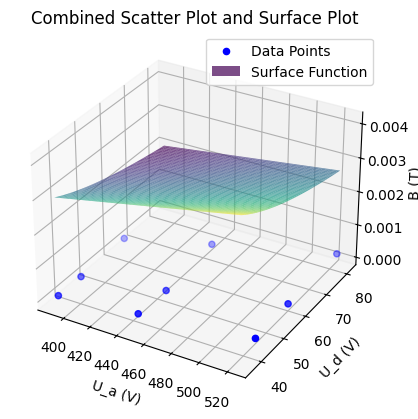

In [20]:

x = df['Ua (V)']
y = df['Ud (V)']
z = df['B (T)']

def f(x, y, d, em):
    return x / (d * np.sqrt(2.0 * y * em))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the scatter points
ax.scatter(x, y, z, color='blue', label='Data Points')

# Create the surface plot
x_grid = np.linspace(min(x), max(x), 100)
y_grid = np.linspace(min(y), max(y), 100)
X, Y = np.meshgrid(x_grid, y_grid)
Z = f(X, Y, DISTANCE, specific_charge_mean)
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7, label='Surface Function')

# Set labels, title, and legend
ax.set_xlabel('U_a (V)')
ax.set_ylabel('U_d (V)')
ax.set_zlabel('B (T)')
ax.set_title('Combined Scatter Plot and Surface Plot')
ax.legend()

# Show the plot
plt.savefig('Magnetic_Field.pdf', bbox_inches='tight')
plt.show()